In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Success: Loaded as Excel file.

DataFrame Columns: ['Temperature(°)', 'W12(um)', 'W34(um)', 'W58(um)', 'W6(um)', 'W7(um)', 'Idc(uA)', 'Length(um)', 'Cl(pF)', 'Cc(pF)', 'Gain(db)', 'Bandwidth(Hz)', 'GBW(MHz)', 'Power(uW)', 'Class']

First 5 rows of DataFrame:
    Temperature(°)  W12(um)  W34(um)  W58(um)  W6(um)  W7(um)  Idc(uA)  \
0             -40     8.00     30.0     18.0    30.0    30.0      130   
1             -40     8.06     30.0     18.0    30.0    30.0      130   
2             -40     8.11     30.0     18.0    30.0    30.0      130   
3             -40     8.17     30.0     18.0    30.0    30.0      130   
4             -40     8.22     30.0     18.0    30.0    30.0      130   

   Length(um)  Cl(pF)  Cc(pF)  Gain(db)  Bandwidth(Hz)  GBW(MHz)  Power(uW)  \
0        0.18      10      55   52.2662        25126.0   28.5279    2145.86   
1        0.18      10      55   52.2797        25164.4   28.8229    2146.22   
2        0.18      10      55   52.2930        25202.4   29.1187

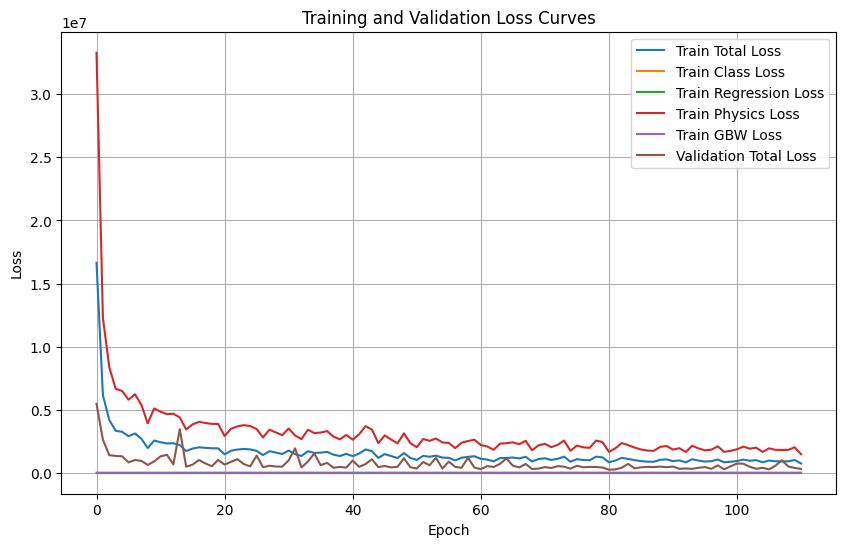

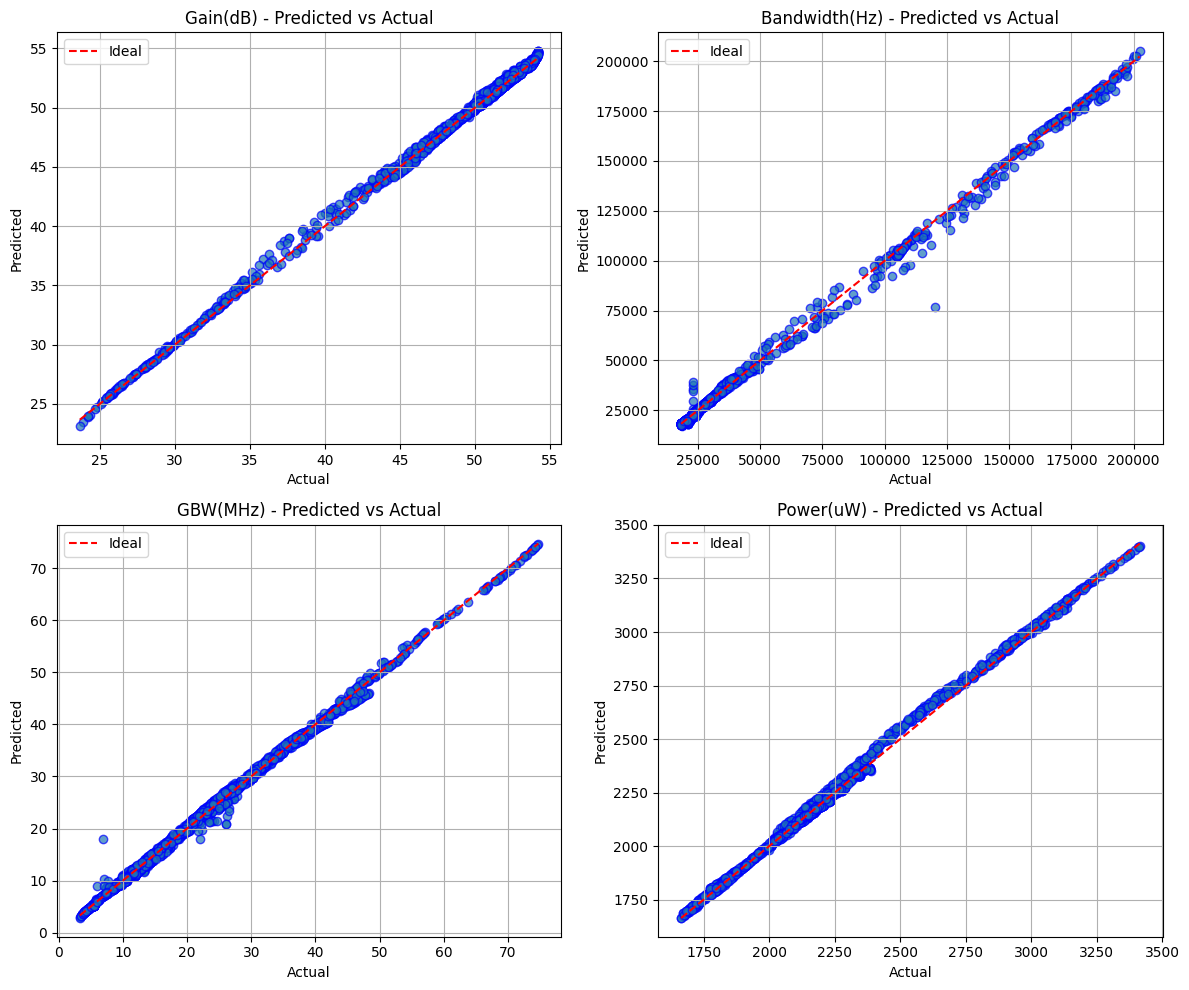

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import numpy as np
import os

# === Reproducibility ===
torch.manual_seed(42)
np.random.seed(42)

# === Load Dataset ===
file_path = '/content/drive/MyDrive/widths_variation (1).csv'

# Validate file existence
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found at: {file_path}. Please check the path.")

# Load as Excel (confirmed .xlsx misnamed as .csv)
try:
    df = pd.read_excel(file_path)
    print("Success: Loaded as Excel file.")
except Exception as e:
    print(f"Failed to load as Excel. Error: {e}")
    try:
        df = pd.read_csv(file_path, encoding='utf-8', sep=None, engine='python')
        print("Success: Loaded as CSV with utf-8 encoding.")
    except Exception as e:
        try:
            df = pd.read_csv(file_path, encoding='latin1', sep=None, engine='python')
            print("Success: Loaded as CSV with latin1 encoding.")
        except Exception as e:
            print("Inspecting first few lines of the file for debugging:")
            with open(file_path, 'r', encoding='latin1') as f:
                for i, line in enumerate(f):
                    if i < 5:
                        print(f"Line {i+1}: {line.strip()}")
            raise Exception(f"Failed to load file with multiple methods. Last error: {e}")

if df is None:
    raise Exception("Failed to load data. Please check the file format and contents.")

# === Inspect and Rename Columns ===
print("\nDataFrame Columns:", list(df.columns))
print("\nFirst 5 rows of DataFrame:\n", df.head())

# Define expected columns
regression_targets = ['Gain(dB)', 'Bandwidth(Hz)', 'GBW(MHz)', 'Power(uW)']
required_columns = ['Class'] + regression_targets

# Column renaming dictionary
column_mapping = {
    'Gain(db)': 'Gain(dB)',
    'gain': 'Gain(dB)',
    'Gain': 'Gain(dB)',
    'gain_db': 'Gain(dB)',
    'Gain (dB)': 'Gain(dB)',
    'bandwidth': 'Bandwidth(Hz)',
    'Bandwidth': 'Bandwidth(Hz)',
    'bandwidth_hz': 'Bandwidth(Hz)',
    'Bandwidth (Hz)': 'Bandwidth(Hz)',
    'gbw': 'GBW(MHz)',
    'GBW': 'GBW(MHz)',
    'gbw_mhz': 'GBW(MHz)',
    'GBW (MHz)': 'GBW(MHz)',
    'power': 'Power(uW)',
    'Power': 'Power(uW)',
    'power_uw': 'Power(uW)',
    'Power (uW)': 'Power(uW)',
    'class': 'Class',
    'CLASS': 'Class',
    'Cl(pF)': 'CL(pF)',
    'Cc(pF)': 'CC(pF)'
}

# Rename columns
df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})

# Validate columns
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    print(f"Warning: Missing columns {missing_columns}. Please verify column names in the Excel file.")
    print("Available columns:", list(df.columns))
    raise ValueError(f"Cannot proceed due to missing required columns: {missing_columns}")

# === Plot GBW Distribution ===
plt.figure(figsize=(8, 6))
plt.hist(df['GBW(MHz)'], bins=50)
plt.title("GBW (Original) Distribution")
plt.xlabel("GBW(MHz)")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig('gbw_distribution_original.png')
plt.close()

# === Set Constants ===
df['Idc(uA)'] = 130.0
df['Length(um)'] = 0.18
df['CL(pF)'] = 10.0
df['CC(pF)'] = 55.0

# === Prepare Inputs and Targets ===
feature_columns = ['Temperature(°)', 'W12(um)', 'W34(um)', 'W58(um)', 'W6(um)', 'W7(um)']
X_raw = df[feature_columns]
y_class = df['Class']
y_regress = df[regression_targets]

# Fill missing values
X_raw = X_raw.fillna(X_raw.mean())
y_class = y_class.fillna(y_class.mode()[0])
y_regress = y_regress.fillna(y_regress.mean())

# Normalize features and targets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

reg_scaler = StandardScaler()
y_regress_scaled = reg_scaler.fit_transform(y_regress)

# === Train-Validation-Test Split ===
train_val_idx, test_idx = train_test_split(range(len(df)), test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.1765, random_state=42)  # 0.1765 * 0.85 ≈ 0.15

X_train = torch.tensor(X_scaled[train_idx], dtype=torch.float32)
X_val = torch.tensor(X_scaled[val_idx], dtype=torch.float32)
X_test = torch.tensor(X_scaled[test_idx], dtype=torch.float32)
y_class_train = torch.tensor(y_class.values[train_idx], dtype=torch.long)
y_class_val = torch.tensor(y_class.values[val_idx], dtype=torch.long)
y_class_test = torch.tensor(y_class.values[test_idx], dtype=torch.long)
y_reg_train = torch.tensor(y_regress_scaled[train_idx], dtype=torch.float32)
y_reg_val = torch.tensor(y_regress_scaled[val_idx], dtype=torch.float32)
y_reg_test = torch.tensor(y_regress_scaled[test_idx], dtype=torch.float32)

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_val, X_test = X_train.to(device), X_val.to(device), X_test.to(device)
y_class_train, y_class_val, y_class_test = y_class_train.to(device), y_class_val.to(device), y_class_test.to(device)
y_reg_train, y_reg_val, y_reg_test = y_reg_train.to(device), y_reg_val.to(device), y_reg_test.to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_class_train, y_reg_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_class_train.cpu().numpy()),
                                     y=y_class_train.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# === PINN Model ===
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, class_output_dim, regression_output_dim=4):
        super(PINN, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.class_head = nn.Linear(hidden_dim, class_output_dim)
        self.regress_head = nn.Linear(hidden_dim, regression_output_dim)
        self.reg_scaler = reg_scaler  # Store scaler for inverse transformation

    def forward(self, x):
        features = self.shared(x)
        return self.class_head(features), self.regress_head(features)

    def physics_loss(self, regress_out, actual_regress):
        # Inverse transform to physical units
        regress_out_real = torch.tensor(self.reg_scaler.inverse_transform(regress_out.detach().cpu().numpy()), dtype=torch.float32).to(regress_out.device)
        actual_regress_real = torch.tensor(self.reg_scaler.inverse_transform(actual_regress.detach().cpu().numpy()), dtype=torch.float32).to(actual_regress.device)

        gain = regress_out_real[:, 0]
        bandwidth = regress_out_real[:, 1]
        gbw_pred = regress_out_real[:, 2]
        power_pred = regress_out_real[:, 3]

        actual_bandwidth = actual_regress_real[:, 1]
        actual_gbw = actual_regress_real[:, 2]

        gbw_expected = gain * actual_bandwidth / 1e6
        loss_gbw = nn.functional.mse_loss(gbw_pred, gbw_expected)

        power_expected = 0.5 * 10 * 55 * actual_bandwidth * 1e-6
        loss_power = nn.functional.mse_loss(power_pred, power_expected)

        gain_expected = torch.clip(gbw_pred * 1e6 / actual_bandwidth, min=0)
        gain_norm = (gain - gain.mean()) / (gain.std() + 1e-6)
        gain_expected_norm = (gain_expected - gain_expected.mean()) / (gain_expected.std() + 1e-6)
        loss_gain = nn.functional.mse_loss(gain_norm, gain_expected_norm)

        gbw_diff = torch.diff(gbw_pred)
        gain_diff = torch.diff(gain)
        trend_violation = torch.relu(-gbw_diff * gain_diff)
        loss_trend = trend_violation.mean() if len(trend_violation) > 0 else torch.tensor(0.0).to(gain.device)

        loss_bandwidth = nn.functional.mse_loss(bandwidth, actual_bandwidth)

        gbw_reg = torch.mean(torch.relu(-gbw_pred) + torch.relu(gbw_pred - 1e3))

        return (
            0.1 * loss_gbw +  # Reduced weight
            0.01 * loss_power +
            0.01 * loss_gain +
            0.001 * loss_trend +
            0.1 * loss_bandwidth +
            0.01 * gbw_reg
        )

# === Train PINN ===
input_dim = X_train.shape[1]
hidden_dim = 512
class_output_dim = len(torch.unique(y_class_train))
regression_output_dim = 4
model = PINN(input_dim, hidden_dim, class_output_dim, regression_output_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_onecycle = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=200, pct_start=0.3)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

criterion_class = nn.CrossEntropyLoss(weight=class_weights)
criterion_regress = nn.MSELoss()

lambda_class = 1.0
lambda_reg = 1.0
lambda_phys = 0.5

best_val_loss = float('inf')
counter = 0
patience = 30  # Increased
loss_history = {'train_total': [], 'train_class': [], 'train_reg': [], 'train_phys': [], 'train_gbw': [], 'val_total': []}

print("\n🚀 Starting Training...")
for epoch in range(200):
    model.train()
    train_total_loss = 0
    train_class_loss = 0
    train_reg_loss = 0
    train_phys_loss = 0
    train_gbw_loss = 0
    for X_batch, y_class_batch, y_reg_batch in train_loader:
        X_batch, y_class_batch, y_reg_batch = X_batch.to(device), y_class_batch.to(device), y_reg_batch.to(device)
        optimizer.zero_grad()
        class_out, regress_out = model(X_batch)
        loss_class = criterion_class(class_out, y_class_batch)
        loss_reg = criterion_regress(regress_out, y_reg_batch)
        loss_phys = model.physics_loss(regress_out, y_reg_batch)
        total_loss = lambda_class * loss_class + lambda_reg * loss_reg + lambda_phys * loss_phys
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_total_loss += total_loss.item()
        train_class_loss += loss_class.item()
        train_reg_loss += loss_reg.item()
        train_phys_loss += loss_phys.item()
        # Compute GBW loss in physical units
        regress_out_real = torch.tensor(reg_scaler.inverse_transform(regress_out.detach().cpu().numpy()), dtype=torch.float32).to(device)
        gbw_pred = regress_out_real[:, 2]
        gbw_expected = regress_out_real[:, 0] * regress_out_real[:, 1] / 1e6
        gbw_loss = nn.functional.mse_loss(gbw_pred, gbw_expected)
        train_gbw_loss += gbw_loss.item()

    train_total_loss /= len(train_loader)
    train_class_loss /= len(train_loader)
    train_reg_loss /= len(train_loader)
    train_phys_loss /= len(train_loader)
    train_gbw_loss /= len(train_loader)

    # Validation
    model.eval()
    with torch.no_grad():
        class_out_val, reg_out_val = model(X_val)
        val_class_loss = criterion_class(class_out_val, y_class_val)
        val_reg_loss = criterion_regress(reg_out_val, y_reg_val)
        val_phys_loss = model.physics_loss(reg_out_val, y_reg_val)
        val_total_loss = lambda_class * val_class_loss + lambda_reg * val_reg_loss + lambda_phys * val_phys_loss

    scheduler_onecycle.step()
    scheduler_plateau.step(train_gbw_loss)

    loss_history['train_total'].append(train_total_loss)
    loss_history['train_class'].append(train_class_loss)
    loss_history['train_reg'].append(train_reg_loss)
    loss_history['train_phys'].append(train_phys_loss)
    loss_history['train_gbw'].append(train_gbw_loss)
    loss_history['val_total'].append(val_total_loss.item())

    if val_total_loss < best_val_loss:
        best_val_loss = val_total_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch}")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_total_loss:.4f} | Class Loss: {train_class_loss:.4f} | Reg Loss: {train_reg_loss:.4f} | Phys Loss: {train_phys_loss:.4f} | GBW Loss: {train_gbw_loss:.4f} | Val Loss: {val_total_loss:.4f}")

print("✅ Training Complete.")

# === Evaluate PINN ===
model.eval()
with torch.no_grad():
    class_logits, reg_preds = model(X_test)
    class_probs = torch.softmax(class_logits, dim=1).cpu().numpy()
    class_preds = np.argmax(class_probs, axis=1)
    y_class_test_np = y_class_test.cpu().numpy()
    reg_preds_np = reg_preds.cpu().numpy()
    y_reg_test_np = y_reg_test.cpu().numpy()

    reg_preds_np_real = reg_scaler.inverse_transform(reg_preds_np)
    y_reg_test_np_real = reg_scaler.inverse_transform(y_reg_test_np)

print("\n📋 Classification Report:")
report = classification_report(y_class_test_np, class_preds)
print(report)

mse_vals = mean_squared_error(y_reg_test_np_real, reg_preds_np_real, multioutput='raw_values')
r2_vals = r2_score(y_reg_test_np_real, reg_preds_np_real, multioutput='raw_values')
mape_vals = np.mean(np.abs((y_reg_test_np_real - reg_preds_np_real) / (y_reg_test_np_real + 1e-6)), axis=0) * 100

print("\n📈 Regression Metrics:")
for i, target in enumerate(regression_targets):
    print(f"{target:15s} | MSE: {mse_vals[i]:.4f} | R²: {r2_vals[i]:.4f} | MAPE: {mape_vals[i]:.2f}%")

# === Save Evaluation Results ===
df_results = pd.DataFrame({
    'True Gain(dB)': y_reg_test_np_real[:, 0],
    'Pred Gain(dB)': reg_preds_np_real[:, 0],
    'True Bandwidth(Hz)': y_reg_test_np_real[:, 1],
    'Pred Bandwidth(Hz)': reg_preds_np_real[:, 1],
    'True GBW(MHz)': y_reg_test_np_real[:, 2],
    'Pred GBW(MHz)': reg_preds_np_real[:, 2],
    'True Power(uW)': y_reg_test_np_real[:, 3],
    'Pred Power(uW)': reg_preds_np_real[:, 3],
    'True Class': y_class_test_np,
    'Pred Class': class_preds
})
df_results.to_excel("PINN_evaluation_results.xlsx", index=False)
print("\n✅ Results saved to: `PINN_evaluation_results.xlsx`")

# === Plot Loss Curves ===
plt.figure(figsize=(10, 6))
plt.plot(loss_history['train_total'], label='Train Total Loss')
plt.plot(loss_history['train_class'], label='Train Class Loss')
plt.plot(loss_history['train_reg'], label='Train Regression Loss')
plt.plot(loss_history['train_phys'], label='Train Physics Loss')
plt.plot(loss_history['train_gbw'], label='Train GBW Loss')
plt.plot(loss_history['val_total'], label='Validation Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

# === Plot Predicted vs Actual ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for i, target in enumerate(regression_targets):
    ax = axes[i]
    ax.scatter(y_reg_test_np_real[:, i], reg_preds_np_real[:, i], alpha=0.7, edgecolors='b')
    ax.plot([y_reg_test_np_real[:, i].min(), y_reg_test_np_real[:, i].max()],
            [y_reg_test_np_real[:, i].min(), y_reg_test_np_real[:, i].max()],
            'r--', label='Ideal')
    ax.set_title(f"{target} - Predicted vs Actual")
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.savefig('regression_plots.png')
plt.show()